# MLB Data Analysis
1. Problem definition
2. Acquire data
3. Data cleaning 
4. Exploratory Data Analysis
5. 
6. Build Model and explain the performance
7. Submit the results.

## 1. Probelm definition
> Predict pitch name based on other variables

In [89]:
# data manipulation
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Machine Learning
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.datasets import make_classification
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
import os
import seaborn as sns

In [90]:
# %pwd
# os.chdir('/Users/kylecamlic/Documents')
# %pwd

## 2. Acquire Data

In [91]:
df = pd.read_csv("statcast_2017.csv")

## 3. Data Cleaning

pitch_name     
4-Seam Fastball    0.347745
Slider             0.162316
2-Seam Fastball    0.129517
Changeup           0.099332
Sinker             0.078767
Curveball          0.078671
Cutter             0.053005
Knuckle Curve      0.029668
Split-Finger       0.016476
Knuckleball        0.003685
Forkball           0.000344
Eephus             0.000258
Pitch Out          0.000162
Screwball          0.000054
dtype: float64


<AxesSubplot:xlabel='pitch_name'>

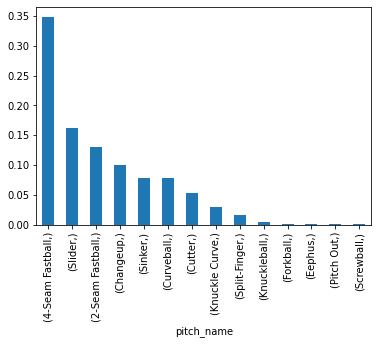

In [92]:
print(df[['pitch_name']].value_counts(normalize= True))
df[['pitch_name']].value_counts(normalize= True).plot(kind = 'bar')

From above we can see 14 types of pitch. For more accurate result, we drop 5 infrequent types, Knuckleball, Forkball, Eephus, Pitch Out and Screwball

In [93]:
#Get rid of Knuckleball, Forkball, Eephus, Pitch Out and Screwball

def filter_rows_by_values(df, col, values):
    return df[~df[col].isin(values)]
    
values = ['Knuckleball','Forkball','Eephus','Pitch Out','Screwball']
print(f'size before removing 5 pitch name {df.shape}')
df = filter_rows_by_values(df,'pitch_name', values)
print(f'size after removing 5 pitch name {df.shape}')

size before removing 5 pitch name (721244, 93)
size after removing 5 pitch name (718011, 93)


In [94]:
# drop columns with high null rate (60%)
print(f"shape of df before dropping high null columns {df.shape}")
df = df.dropna(thresh=df.shape[0]*0.6,how='all',axis=1)
print(f"shape of df after dropping high null columns {df.shape}")

# get rid of all null rows
print(f"size before droping high null columns {df.shape}")
df = df.dropna()
print(f"size after droping high null columns {df.shape}")

shape of df before dropping high null columns (718011, 93)
shape of df after dropping high null columns (718011, 67)
size before droping high null columns (718011, 67)
size after droping high null columns (700635, 67)


## Exploratory Data Analysis

We will first start with PCA to see whether pitch_name is seperable

In [95]:
# choose the columns that we chose earlier in the meeting
df_pca = df[['pitch_name','release_speed', 'release_pos_x', 'release_pos_z', 'release_spin_rate']]

In [96]:
# drop all the null values before running PCA
print(f"size before droping null values {df_pca.shape}")
df_pca = df_pca.dropna()
print(f"size after droping null values {df_pca.shape}")

size before droping null values (700635, 5)
size after droping null values (700635, 5)


In [97]:
# Choose 1,000 samples and run PCA to see whether there are clusters
df_pca = df_pca.sample(n=1000, random_state=1)
df_pca_X = df_pca.drop('pitch_name',axis = 1)

pca = PCA(n_components=2)
components = pca.fit_transform(df_pca_X)

In [98]:
print(pca.explained_variance_ratio_)


[9.99580878e-01 3.79475885e-04]


In [99]:
components[:,0]
fig = px.scatter(components, x=components[:,0], y=components[:,1], color = df_pca.pitch_name, hover_name = df_pca.pitch_name)
fig.show()

This time let's try PCA with all the "Important Columns" by choosing KBest

In [100]:
#In this section let's try to use ANOVA feature selection for numeric input and categorical output. 
#In other words, let's try to choose numerical columns that correlates with our target variables
# Choose X
df_pca_15 = df.sample(n=1000, random_state=1)
X = df_pca_15.select_dtypes(include=np.number)
print(X.columns)
X.head()

Index(['Unnamed: 0', 'release_speed', 'release_pos_x', 'release_pos_z',
       'batter', 'pitcher', 'zone', 'balls', 'strikes', 'game_year', 'pfx_x',
       'pfx_z', 'plate_x', 'plate_z', 'outs_when_up', 'inning', 'fielder_2',
       'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az', 'sz_top', 'sz_bot',
       'effective_speed', 'release_spin_rate', 'release_extension', 'game_pk',
       'pitcher.1', 'fielder_2.1', 'fielder_3', 'fielder_4', 'fielder_5',
       'fielder_6', 'fielder_7', 'fielder_8', 'fielder_9', 'release_pos_y',
       'at_bat_number', 'pitch_number', 'home_score', 'away_score',
       'bat_score', 'fld_score', 'post_away_score', 'post_home_score',
       'post_bat_score', 'post_fld_score', 'spin_axis', 'delta_home_win_exp',
       'delta_run_exp'],
      dtype='object')


,Unnamed: 0,release_speed,release_pos_x,release_pos_z,batter,pitcher,zone,balls,strikes,game_year,...,away_score,bat_score,fld_score,post_away_score,post_home_score,post_bat_score,post_fld_score,spin_axis,delta_home_win_exp,delta_run_exp
683266,3350,100.2,0.72,6.09,595281,547973,1.0,0,1,2017,...,4,4,8,4,8,4,8,156.0,0.000,-0.112
211520,1254,96.8,-1.96,5.88,571448,570632,11.0,2,0,2017,...,0,0,0,0,0,0,0,228.0,0.000,-0.061
466085,4356,95.5,-1.08,6.09,571437,592422,14.0,0,0,2017,...,3,3,1,3,1,3,1,241.0,0.000,-0.037
59849,3703,91.0,2.13,5.97,605412,519008,5.0,1,1,2017,...,2,5,2,2,5,5,2,113.0,0.008,0.396
595821,190,97.0,-1.45,6.21,459964,605242,7.0,0,0,2017,...,5,1,5,5,1,1,5,234.0,-0.005,-0.106


In [101]:
X = X.drop(['Unnamed: 0','batter', 'pitcher'], axis = 1)
X

,release_speed,release_pos_x,release_pos_z,zone,balls,strikes,game_year,pfx_x,pfx_z,plate_x,...,away_score,bat_score,fld_score,post_away_score,post_home_score,post_bat_score,post_fld_score,spin_axis,delta_home_win_exp,delta_run_exp
683266,100.2,0.72,6.09,1.0,0,1,2017,0.66,1.58,-0.28,...,4,4,8,4,8,4,8,156.0,0.000,-0.112
211520,96.8,-1.96,5.88,11.0,2,0,2017,-1.11,1.13,-1.09,...,0,0,0,0,0,0,0,228.0,0.000,-0.061
466085,95.5,-1.08,6.09,14.0,0,0,2017,-1.49,0.93,1.07,...,3,3,1,3,1,3,1,241.0,0.000,-0.037
59849,91.0,2.13,5.97,5.0,1,1,2017,1.78,0.87,-0.02,...,2,5,2,2,5,5,2,113.0,0.008,0.396
595821,97.0,-1.45,6.21,7.0,0,0,2017,-1.30,0.92,-0.29,...,5,1,5,5,1,1,5,234.0,-0.005,-0.106
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
213188,96.0,2.23,6.23,13.0,2,0,2017,0.44,1.42,-1.03,...,5,6,5,5,6,6,5,161.0,0.000,0.071
213291,94.3,-1.81,6.74,11.0,0,0,2017,-0.29,1.66,-0.91,...,1,6,1,1,6,6,1,191.0,0.000,-0.026
70426,83.7,-1.25,5.74,14.0,1,1,2017,0.67,0.75,1.17,...,1,1,1,1,1,1,1,132.0,0.000,0.091
325309,91.7,-3.21,5.55,11.0,1,0,2017,-1.69,0.80,-1.17,...,1,4,1,1,4,4,1,248.0,0.000,-0.110


In [102]:
# Create and fit selector
selector = SelectKBest(score_func=f_classif, k=15)
selector.fit(X, df_pca_15.pitch_name)
# Get columns to keep and create new dataframe with those only
cols = selector.get_support(indices=True)
X_new = X.iloc[:,cols]
X_new

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning:

Features [6] are constant.

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning:

invalid value encountered in true_divide



,release_speed,zone,pfx_x,pfx_z,plate_z,vy0,vz0,ax,ay,az,effective_speed,release_spin_rate,release_extension,release_pos_y,spin_axis
683266,100.2,1.0,0.66,1.58,3.41,-145.547865,-5.839838,10.533609,35.112347,-8.215020,100.9,2646.0,6.8,53.70,156.0
211520,96.8,11.0,-1.11,1.13,2.55,-140.459214,-5.792084,-15.721844,34.888658,-16.195078,96.0,2231.0,6.2,54.32,228.0
466085,95.5,14.0,-1.49,0.93,2.70,-138.390302,-5.203377,-20.398154,29.349161,-19.712498,93.8,2326.0,5.4,55.11,241.0
59849,91.0,5.0,1.78,0.87,2.25,-131.856651,-5.156877,22.294844,27.451988,-21.310271,89.9,2005.0,5.8,54.69,113.0
595821,97.0,7.0,-1.30,0.92,2.03,-140.998062,-7.746431,-18.773606,32.020170,-18.244605,97.2,2058.0,6.5,54.04,234.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
213188,96.0,13.0,0.44,1.42,0.68,-138.724673,-11.960460,7.574681,29.469577,-11.858966,94.6,2240.0,5.8,54.75,161.0
213291,94.3,11.0,-0.29,1.66,2.91,-136.884493,-7.866150,-4.256904,28.617502,-9.855412,94.1,2064.0,6.2,54.31,191.0
70426,83.7,14.0,0.67,0.75,1.29,-121.445217,-5.173673,5.712858,21.885968,-24.299244,82.4,2475.0,5.4,55.13,132.0
325309,91.7,11.0,-1.69,0.80,2.77,-133.137144,-2.948982,-22.363288,27.910605,-22.045098,92.4,2061.0,6.8,53.71,248.0


In [103]:
pca = PCA(n_components=2)
components = pca.fit_transform(X_new)
print(pca.explained_variance_ratio_)

[0.95220409 0.044708  ]


In [104]:
components[:,0]
fig = px.scatter(components, x=components[:,0], y=components[:,1], color = df_pca_15.pitch_name, hover_name = df_pca_15.pitch_name)
fig.show()

In [120]:
#The above result shows the 15 best columns to choose to make a classification model,we predict pitch type
pivot= df.groupby(by = 'pitch_name').mean()['release_speed']

df['mean_speed_by_pitch'] = df

pitch_name
2-Seam Fastball    92.504522
4-Seam Fastball    93.240590
Changeup           84.181456
Curveball          77.807143
Cutter             88.460283
Knuckle Curve      80.429037
Sinker             91.560689
Slider             84.521118
Split-Finger       84.700960
Name: release_speed, dtype: float64

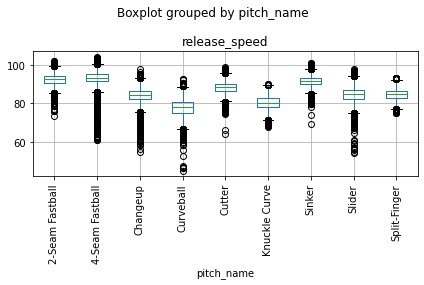

In [107]:

df.boxplot(column = 'release_speed', by = 'pitch_name')
ax = plt.gca()
ax.tick_params(axis='x', labelrotation = 90)
# plt.xlabel(rotation = 90)
plt.tight_layout()

In [19]:
#------------------- lets look at some of these columns and their relationships

In [20]:
#analyze pitch type of all pitches above 90 miles an hour 
rel_speed_above_90 = df[df.release_speed > 90]
rel_speed_above_90

,Unnamed: 0,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,description,...,fld_score,post_away_score,post_home_score,post_bat_score,post_fld_score,if_fielding_alignment,of_fielding_alignment,spin_axis,delta_home_win_exp,delta_run_exp
0,2265,FC,2017-10-01,91.9,-1.19,5.99,"Osuna, Roberto",595885,532077,hit_into_play,...,2,2,1,1,2,Infield shift,Strategic,183.0,-0.044,-0.124
1,2350,FC,2017-10-01,91.8,-1.08,6.18,"Osuna, Roberto",595885,532077,foul,...,2,2,1,1,2,Infield shift,Strategic,164.0,-0.044,-0.035
2,2397,FF,2017-10-01,94.7,-0.62,6.34,"Osuna, Roberto",595885,532077,ball,...,2,2,1,1,2,Infield shift,Strategic,189.0,-0.044,0.038
4,2666,FT,2017-10-01,95.9,-0.89,6.13,"Osuna, Roberto",595885,532077,ball,...,2,2,1,1,2,Infield shift,Strategic,221.0,-0.044,0.014
5,2780,FF,2017-10-01,96.0,-0.96,6.21,"Osuna, Roberto",595885,532077,called_strike,...,2,2,1,1,2,Infield shift,Strategic,203.0,-0.044,-0.018
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
721238,761,FT,2017-04-02,96.3,-1.36,5.24,"Martínez, Carlos",592178,593372,ball,...,0,0,0,0,0,Standard,Standard,245.0,0.000,0.042
721239,788,FT,2017-04-02,98.4,-1.23,5.15,"Martínez, Carlos",592178,593372,called_strike,...,0,0,0,0,0,Standard,Standard,246.0,0.000,-0.060
721241,837,FT,2017-04-02,97.3,-1.32,5.18,"Martínez, Carlos",656941,593372,ball,...,0,0,0,0,0,Standard,Standard,252.0,0.000,0.050
721242,876,FT,2017-04-02,95.9,-1.31,5.48,"Martínez, Carlos",656941,593372,foul,...,0,0,0,0,0,Standard,Standard,245.0,0.000,-0.046


pitch_name     
4-Seam Fastball    0.619089
2-Seam Fastball    0.216629
Sinker             0.118179
Cutter             0.029404
Slider             0.010941
Changeup           0.005238
Split-Finger       0.000494
Curveball          0.000020
Knuckle Curve      0.000006
dtype: float64


<AxesSubplot:xlabel='pitch_name'>

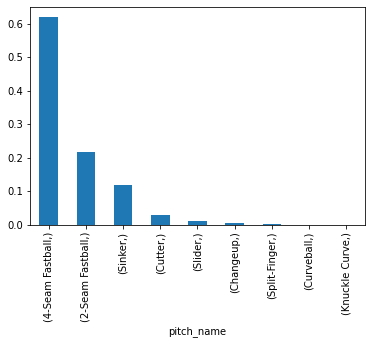

In [21]:
#print the percentages of certain pitches that are thrown at 90 mph or faster
print(rel_speed_above_90[['pitch_name']].value_counts(normalize= True))
rel_speed_above_90[['pitch_name']].value_counts(normalize= True).plot(kind = 'bar')
 

In [22]:
#what is the relationship between pitch_name and pfx_x, pfx_z since these variables are a little more complicated 
#and are not as self-explanatory

In [23]:
#what is pfx_x? It is the horizontal movement, in inches, of the pitch between the release point and home plate,
#as compared to a theoretical pitch thrown at the same speed with no spin-induced movement

In [24]:
#now that we know what pfx_x is, lets look at its relationship with pitch_name and look at its range
print(df.pfx_x.max())
print(df.pfx_x.min())

2.93
-4.15


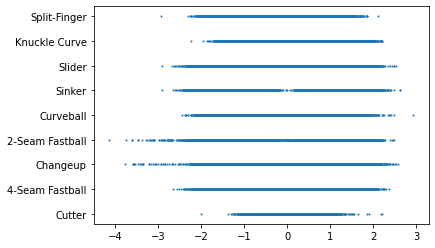

In [25]:
#lets see how the magnitude of pfx_x impacts pitch_name, generally speaking
pfx_x_col = df['pfx_x']

pitch_name_col = df['pitch_name']

plt.scatter(pfx_x_col, pitch_name_col, s=1, alpha=1)
plt.show()

In [26]:
#This helps us visualize where given pitches tend to end up on the pfx_x 'scale' 

In [27]:
pfx_x_above2 = df[df.pfx_x > 2]
print(pfx_x_above2)

        Unnamed: 0 pitch_type   game_date  release_speed  release_pos_x  \
2777          4102         CH  2017-10-01           80.7           2.29   
5004          3567         FT  2017-09-30           94.5           2.24   
6058          3525         SI  2017-09-30           88.2           3.76   
6061          4006         SI  2017-09-30           90.2           3.67   
6063          4309         SI  2017-09-30           89.1           3.57   
...            ...        ...         ...            ...            ...   
717292        2177         SI  2017-04-03           94.8           0.95   
717295        2468         SL  2017-04-03           79.8          -3.49   
717302        2234         SI  2017-04-03           97.1           0.80   
717306        2668         SI  2017-04-03           96.5           0.88   
717982        1167         SL  2017-04-03           79.5          -1.34   

        release_pos_z      player_name  batter  pitcher      description  ...  \
2777             6

pitch_name     
Changeup           0.240157
Sinker             0.226378
2-Seam Fastball    0.173228
Slider             0.161417
4-Seam Fastball    0.072835
Knuckle Curve      0.062992
Curveball          0.057087
Cutter             0.003937
Split-Finger       0.001969
dtype: float64


<AxesSubplot:xlabel='pitch_name'>

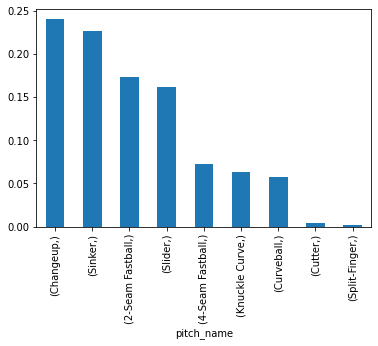

In [28]:
#all this data is for pitches with a pfx_x value of greater than 2
print(pfx_x_above2[['pitch_name']].value_counts(normalize= True))
pfx_x_above2[['pitch_name']].value_counts(normalize= True).plot(kind = 'bar')

In [29]:
df_sample1 = df.sample(n=1000,replace=True)

In [30]:
print(df.release_spin_rate.max())
print(df.release_spin_rate.min())

3680.0
413.0


<function matplotlib.pyplot.legend(*args, **kwargs)>

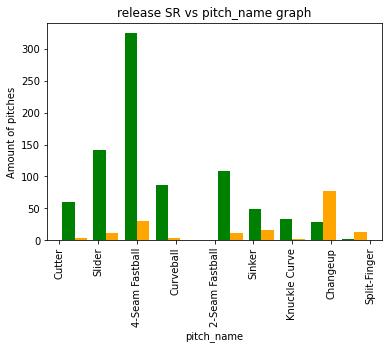

In [31]:
pitch_name_release_spin_rate_under_2000 = df_sample1[df_sample1.release_spin_rate < 2000].pitch_name
pitch_name_release_spin_rate_over_2000 = df_sample1[df_sample1.release_spin_rate > 2000].pitch_name

plt.xlabel('pitch_name')
plt.ylabel('Amount of pitches')
plt.title('release SR vs pitch_name graph')


plt.hist([pitch_name_release_spin_rate_over_2000, pitch_name_release_spin_rate_under_2000], color=['green', 'orange'], label=['RSR over 2000', 'RSR under 2000'])
plt.xticks(rotation=90)
plt.legend

In [32]:
#we see here that changeups and split-finger have very low spin rates comparatively
#this is only for our sample of 1000 pitches, but it gives us a good idea

In [33]:
#create database with only 4 seam fastball pitches
four_seam_fastball = df[df.pitch_name == '4-Seam Fastball']

In [34]:
#lets assess the typical ax value four a four seam fastball 
#ax value is the acceleration of the pitch, in feet per second per second, in x-dimension, determined at y=50 feet.
four_seam_fastball.head()

,Unnamed: 0,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,description,...,fld_score,post_away_score,post_home_score,post_bat_score,post_fld_score,if_fielding_alignment,of_fielding_alignment,spin_axis,delta_home_win_exp,delta_run_exp
2,2397,FF,2017-10-01,94.7,-0.62,6.34,"Osuna, Roberto",595885,532077,ball,...,2,2,1,1,2,Infield shift,Strategic,189.0,-0.044,0.038
5,2780,FF,2017-10-01,96.0,-0.96,6.21,"Osuna, Roberto",595885,532077,called_strike,...,2,2,1,1,2,Infield shift,Strategic,203.0,-0.044,-0.018
8,3056,FF,2017-10-01,96.7,-0.64,6.26,"Osuna, Roberto",407812,532077,foul,...,2,2,1,1,2,Standard,Standard,204.0,0.000,0.000
9,3148,FF,2017-10-01,95.6,-0.87,6.16,"Osuna, Roberto",407812,532077,called_strike,...,2,2,1,1,2,Standard,Standard,212.0,0.000,-0.045
10,3330,FF,2017-10-01,95.4,-1.06,6.13,"Osuna, Roberto",407812,532077,swinging_strike,...,2,2,1,1,2,Standard,Standard,205.0,0.000,-0.032


In [35]:
four_seam_fastball['ax'].mean()

-4.827034304602974

In [36]:
#so on the mean ax value 
#(The acceleration of the pitch, in feet per second per second, in x-dimension, determined at y=50 feet)
#four all 4-seam fastballs is -4.827034304602899

In [37]:
print(four_seam_fastball['release_pos_z'].mean())
print(four_seam_fastball['release_speed'].mean())

5.956987308593735
93.24059038958636


In [38]:
#average 4-seam fastball velocity is 93.24 mph and 
#release_pos_z or (Vertical Release Position of the ball measured in feet from the catcher's perspective) is 5.96 feet